In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Load CSVs (merge real+synthetic)
signal_real = pd.read_csv("./combined-dataset/real-signal-injected.csv", header=None).astype(float)
signal_syn = pd.read_csv("./combined-dataset/synthetic-signal-injected.csv", header=None).astype(float)
noise_real = pd.read_csv("./combined-dataset/real-noise.csv", header=None).astype(float)
noise_syn = pd.read_csv("./combined-dataset/synthetic-noise.csv", header=None).astype(float)

signal_real["label"] = 1
signal_syn["label"] = 1
noise_real["label"] = 0
noise_syn["label"] = 0

# Combine dataset (adjust ratio if needed)
train_data = pd.concat([signal_real, signal_syn, noise_real, noise_syn], axis=0)
train_data = shuffle(train_data, random_state=42)

X = train_data.iloc[:, :-1].values
y = train_data["label"].values.astype(np.float32)

# Normalize based on pure noise only
noise_all = pd.concat([noise_real, noise_syn], axis=0)
scaler = StandardScaler()
scaler.fit(noise_all.iloc[:, :-1])
X = scaler.transform(X)

# Expand for CNN input
X = np.expand_dims(X, axis=-1)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU,
                                     MaxPooling1D, Dropout, GlobalAveragePooling1D,
                                     Dense, Add)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def residual_block(x, filters, kernel_size=8, pool_size=4, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    # Residual connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding = 'same')(shortcut)
    x = Add()([shortcut, x])
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=pool_size)(x)
    x = Dropout(dropout_rate)(x)
    return x

def build_best_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    # Initial Conv
    x = Conv1D(32, 16, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=4)(x)

    # Residual Blocks
    x = residual_block(x, 64, 8, pool_size=4, dropout_rate=0.3)
    x = residual_block(x, 128, 8, pool_size=4, dropout_rate=0.3)
    x = residual_block(x, 256, 4, pool_size=4, dropout_rate=0.4)

    # Global feature aggregation
    x = Conv1D(512, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling1D()(x)

    # Classifier
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_best_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred = model.predict(X_val).ravel()

Epoch 1/50
448/448 [==============================] - 55s 99ms/step - loss: 0.7123 - accuracy: 0.5062 - val_loss: 0.7531 - val_accuracy: 0.5000
Epoch 2/50
448/448 [==============================] - 44s 99ms/step - loss: 0.6961 - accuracy: 0.5150 - val_loss: 0.7352 - val_accuracy: 0.5028
Epoch 3/50
448/448 [==============================] - 44s 98ms/step - loss: 0.6815 - accuracy: 0.5453 - val_loss: 0.7278 - val_accuracy: 0.6763
Epoch 4/50
448/448 [==============================] - 46s 103ms/step - loss: 0.4792 - accuracy: 0.7183 - val_loss: 0.6080 - val_accuracy: 0.7101
Epoch 5/50
448/448 [==============================] - 44s 99ms/step - loss: 0.3918 - accuracy: 0.7605 - val_loss: 0.5995 - val_accuracy: 0.7715
Epoch 6/50
448/448 [==============================] - 46s 103ms/step - loss: 0.3729 - accuracy: 0.7819 - val_loss: 0.5845 - val_accuracy: 0.7868
Epoch 7/50
448/448 [==============================] - 45s 99ms/step - loss: 0.3610 - accuracy: 0.7879 - val_loss: 0.5191 - val_accurac

ROC AUC Score: 0.958665808852838
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      1792
         1.0       0.96      0.80      0.88      1792

    accuracy                           0.89      3584
   macro avg       0.90      0.89      0.88      3584
weighted avg       0.90      0.89      0.88      3584



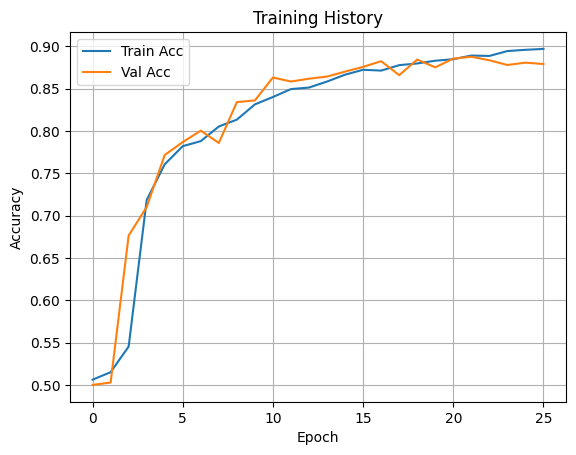

In [4]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()